In [90]:
import os 
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../")))

In [91]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from sklearn.model_selection import train_test_split
from matplotlib.ticker import ScalarFormatter

# Own library imports
from vecopsciml.utils import TensOps
from vecopsciml.operators.zero_order import Mx, My
from vecopsciml.kernels.derivative import DerivativeKernels
from vecopsciml.operators import zero_order as zo
from vecopsciml.algebra import zero_order as azo

# Function from this project
from utils.folders import create_folder
from utils.load_data import load_data
from trainers.train import train_loop
from utils.checkpoints import load_results

# Import model
from architectures.autoencoder import Autoencoder

In [92]:
# Dataset
dataset = 'non_linear'
N_data = 1000
noise = 1

data_name = dataset + '_' + str(N_data) + '_' + str(noise)
print(data_name)

non_linear_1000_1


In [93]:
# Model
model = 'autoencoder'
n_modes = 10

model_name = model + '_model_' + str(n_modes)
print(model_name)

autoencoder_model_10


In [94]:
ROOT_PATH = os.path.abspath(os.path.join(os.getcwd(), "../../"))
DATA_PATH = os.path.join(ROOT_PATH, r'data/', data_name, data_name) + '.pkl'
RESULTS_FOLDER_PATH = os.path.join(ROOT_PATH, r'results/', data_name)

MODEL_RESULTS_AE_PATH = os.path.join(ROOT_PATH, r'results/', data_name, model_name) + '_AE'
MODEL_RESULTS_PGNNIV_PATH = os.path.join(ROOT_PATH, r'results/', data_name, model_name) + '_NN'

# Create necessary folders (if already created, a message will be shown)
create_folder(RESULTS_FOLDER_PATH)
create_folder(MODEL_RESULTS_AE_PATH)
create_folder(MODEL_RESULTS_PGNNIV_PATH)

Folder already exists at: /home/rmunoz/Escritorio/rmunozTMELab/Embedding-Oriented-PGNNIV/results/non_linear_1000_1
Folder already exists at: /home/rmunoz/Escritorio/rmunozTMELab/Embedding-Oriented-PGNNIV/results/non_linear_1000_1/autoencoder_model_10_AE
Folder already exists at: /home/rmunoz/Escritorio/rmunozTMELab/Embedding-Oriented-PGNNIV/results/non_linear_1000_1/autoencoder_model_10_NN


In [95]:
# Load dataset
dataset = load_data(DATA_PATH)

Data successfully loaded from: /home/rmunoz/Escritorio/rmunozTMELab/Embedding-Oriented-PGNNIV/data/non_linear_1000_1/non_linear_1000_1.pkl


In [96]:
# Convolutional filters to derivate
dx = dataset['x_step_size']
dy = dataset['y_step_size']
D = DerivativeKernels(dx, dy, 0).grad_kernels_two_dimensions()

In [97]:
DEVICE = torch.device("cpu")

print(f"Using device: {DEVICE}")

Using device: cpu


In [98]:
X_train = torch.Tensor(dataset['X_train']).unsqueeze(1).to(torch.float32)
y_train = torch.Tensor(dataset['y_train']).unsqueeze(1).to(torch.float32)
K_train = torch.tensor(dataset['k_train']).unsqueeze(1).to(torch.float32)
f_train = torch.tensor(dataset['f_train']).unsqueeze(1).to(torch.float32)

X_val = torch.Tensor(dataset['X_val']).to(torch.float32).unsqueeze(1)
y_val = TensOps(torch.Tensor(dataset['y_val']).to(torch.float32).unsqueeze(1).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)
K_val = TensOps(torch.tensor(dataset['k_val']).to(torch.float32).unsqueeze(1).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)
f_val = TensOps(torch.tensor(dataset['f_val']).to(torch.float32).unsqueeze(1).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)

print("Train dataset length:", len(X_train))
print("Validation dataset length:", len(X_val))

Train dataset length: 800
Validation dataset length: 200


In [99]:
N_data_AE = len(X_train)//4
N_data_NN = len(X_train) - len(X_train)//4
prop_data_NN = 1 - N_data_AE/(N_data_NN + N_data_AE)

print("Dataset length for the autoencoder:", N_data_AE)
print("Dataset length for the PGNNIV:", N_data_NN)

X_AE, X_NN, y_AE, y_NN, K_AE, K_NN, f_AE, f_NN = train_test_split(X_train, y_train, K_train, f_train, test_size=prop_data_NN, random_state=42)

Dataset length for the autoencoder: 200
Dataset length for the PGNNIV: 600


In [100]:
X_train_NN, X_test_NN, y_train_NN, y_test_NN, K_train_NN, K_test_NN, f_train_NN, f_test_NN = train_test_split(X_NN, y_NN, K_NN, f_NN, test_size=0.2, random_state=42)

X_train_NN = X_train_NN.to(DEVICE)
X_test_NN = X_test_NN.to(DEVICE)

y_train_NN = TensOps(y_train_NN.requires_grad_(True).to(DEVICE), space_dimension=2, contravariance=0, covariance=0)
y_test_NN = TensOps(y_test_NN.requires_grad_(True).to(DEVICE), space_dimension=2, contravariance=0, covariance=0)

K_train_NN = TensOps(K_train_NN.to(DEVICE), space_dimension=2, contravariance=0, covariance=0)
K_test_NN = TensOps(K_test_NN.to(DEVICE), space_dimension=2, contravariance=0, covariance=0)

f_train_NN = TensOps(f_train_NN.to(DEVICE), space_dimension=2, contravariance=0, covariance=0)
f_test_NN = TensOps(f_test_NN.to(DEVICE), space_dimension=2, contravariance=0, covariance=0)

In [101]:
# Predictive network architecture
input_shape = X_train_NN[0].shape
predictive_layers =  [20, 10, n_modes, 10, 20]
predictive_output = y_train_NN.values[0].shape

# Explanatory network architecture
explanatory_input = Mx(My(y_train_NN)).values[0].shape
explanatory_layers = [10, 10]
explanatory_output = Mx(My(f_train_NN)).values[0].shape

# Other parameters
n_filters_explanatory = 5

In [102]:
from architectures.autoencoder import Autoencoder
from architectures.pgnniv_decoder import PGNNIVAutoencoder

In [103]:
y_train_AE, y_test_AE = train_test_split(y_AE, test_size=0.2, random_state=42)

y_train_AE = TensOps(y_train_AE.requires_grad_(True).to(DEVICE), space_dimension=2, contravariance=0, covariance=0)
y_test_AE = TensOps(y_test_AE.requires_grad_(True).to(DEVICE), space_dimension=2, contravariance=0, covariance=0)

In [104]:
autoencoder_input_shape = y_train_AE.values[0].shape
latent_space_dim = [20, 10, n_modes, 10, 20]
autoencoder_output_shape = y_train_AE.values[0].shape

autoencoder = Autoencoder(autoencoder_input_shape, latent_space_dim, autoencoder_output_shape).to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-4)

autoencoder, optimizer, lists = load_results(autoencoder, optimizer, MODEL_RESULTS_AE_PATH, map_location=torch.device('cpu'))

In [105]:
pretrained_encoder = autoencoder.encoder
pretrained_decoder = autoencoder.decoder

In [106]:
# Se carga el modelo y el optimizador
pgnniv_model = PGNNIVAutoencoder(input_shape, predictive_layers, pretrained_decoder, predictive_output, explanatory_input,
                                   explanatory_layers, explanatory_output, n_filters_explanatory).to(DEVICE)
optimizer = torch.optim.Adam(pgnniv_model.parameters(), lr=1e-4)

model, optimizer, lists = load_results(pgnniv_model, optimizer, MODEL_RESULTS_PGNNIV_PATH, map_location=torch.device('cpu'))

In [107]:
time_list = lists['time_list']

train_total_loss_list = lists['train_total_loss_list']
train_e_loss_list = lists['train_e_loss_list']
train_pi1_loss_list = lists['train_pi1_loss_list']
train_pi2_loss_list = lists['train_pi2_loss_list']
train_pi3_loss_list = lists['train_pi3_loss_list']

test_total_loss_list = lists['test_total_loss_list']
test_e_loss_list = lists['test_e_loss_list']
test_pi1_loss_list = lists['test_pi1_loss_list']
test_pi2_loss_list = lists['test_pi2_loss_list']
test_pi3_loss_list = lists['test_pi3_loss_list']

In [ ]:
def smooth_curve(data, window_size=100):
    window = np.ones(window_size) / window_size
    return np.convolve(data, window, mode='valid')

def cm_to_in(cm):
    return cm * 0.393701

def normalize_list(lst):
    max_value = np.max(lst)
    return [x / max_value for x in lst]

linewidth = 1.5  
title_fontsize = 14  
label_fontsize = 14  
legend_fontsize = 12 
tick_fontsize = 11  

plt.rc('font', family='serif')

posX = cm_to_in(10) # position of the lower left corner of the image in X
posY = cm_to_in(10) # position of the lower left corner of the image in Y
width = cm_to_in(12)  # image width
height = cm_to_in(8) # image height

color = [0.1, 0, 0.8]  # RGB triplet, values between 0 and 1
subplot_adjust_left = cm_to_in(0.15)
subplot_adjust_bottom = cm_to_in(0.15)

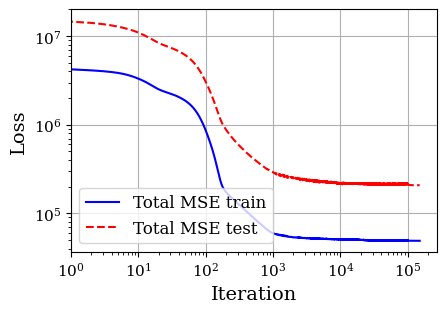

In [ ]:
plt.figure(figsize=(width, height))

plt.plot(smooth_curve(train_total_loss_list), label='Total MSE train', color='blue', linestyle='-')
plt.plot(smooth_curve(test_total_loss_list), label='Total MSE test', color='red', linestyle='--')

plt.xlabel('Iteration', fontsize=label_fontsize)
plt.ylabel('Loss', fontsize=label_fontsize)

plt.grid(True)
plt.legend(loc='lower left', fontsize=legend_fontsize)
plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)

plt.xscale('log')
plt.yscale('log')
plt.xlim(left=1) 

plt.show()

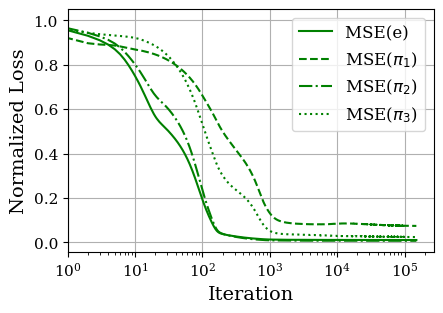

In [ ]:
plt.figure(figsize=(width, height))

plt.plot(normalize_list(smooth_curve(train_e_loss_list)), label=r'MSE(e) ', color='green', linestyle='-')
plt.plot(normalize_list(smooth_curve(train_pi1_loss_list)), label=r'MSE($\pi_1$) ', color='green', linestyle='--')
plt.plot(normalize_list(smooth_curve(train_pi2_loss_list)), label=r'MSE($\pi_2$) ', color='green', linestyle='-.')
plt.plot(normalize_list(smooth_curve(train_pi3_loss_list)), label=r'MSE($\pi_3$) ', color='green', linestyle=':')

plt.xlabel('Iteration', fontsize=label_fontsize)
plt.ylabel('Normalized Loss', fontsize=label_fontsize)

plt.grid(True)
plt.legend(loc='upper right', fontsize=legend_fontsize)
plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)

plt.xscale('log')
plt.xlim(left=1) 

plt.show()

In [ ]:
def relative_error_stats(validation, prediction, dx=dx, dy=dy):

    validation = validation.numpy()
    prediction = prediction.numpy()

    prediction_error = np.sqrt((np.trapz(np.trapz((validation - prediction)**2, dx=dy), dx=dx) /
                                np.trapz(np.trapz((validation)**2, dx=dy), dx=dx)))

    minimum = np.min(prediction_error)
    maximum = np.max(prediction_error)
    first_quartile = np.percentile(prediction_error, 25)
    median = np.percentile(prediction_error, 50)
    third_quartile = np.percentile(prediction_error, 75)

    # Print the results
    print(f"Minimum: {minimum:.2e}")
    print(f"First quartile (Q1): {first_quartile:.2e}")
    print(f"Median (Q2): {median:.2e}")
    print(f"Third quartile (Q3): {third_quartile:.2e}")
    print(f"Maximum: {maximum:.2e}")


def relative_error_return_Q(validation, prediction, dx=dx, dy=dy):

    validation = validation.numpy()
    prediction = prediction.numpy()

    prediction_error = np.sqrt((np.trapz(np.trapz((validation - prediction)**2, dx=dy), dx=dx)/
                                np.trapz(np.trapz((validation)**2, dx=dy), dx=dx)))
    third_quartile = np.percentile(prediction_error, 75)

    Q_bool = prediction_error <= third_quartile

    return Q_bool

In [112]:
y_pred, K_pred = model(X_val)

y_pred = TensOps(y_pred, space_dimension=2, contravariance=0, covariance=0)
K_pred = TensOps(K_pred, space_dimension=2, contravariance=0, covariance=0)

### Solution $u(x,y)$

In [113]:
u_validation = y_val.values.detach()
u_prediction = y_pred.values.detach()

relative_error_stats(u_validation, u_prediction)

Mínimo: 1.00e-02
Primer cuartil (Q1): 1.19e-02
Mediana (Q2): 1.28e-02
Tercer cuartil (Q3): 1.37e-02
Máximo: 1.92e-01


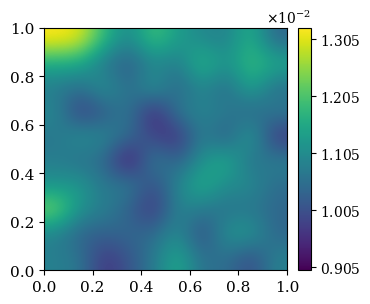

In [ ]:
plt.figure(figsize=(height*1.2, height))

u_diff = torch.mean(torch.abs(u_prediction - u_validation), axis=0).squeeze()
plt.imshow(u_diff, interpolation='bicubic', extent=[0, 1, 0, 1])

cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.formatter = ScalarFormatter(useMathText=True)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()

# Get automatically generated ticks
ticks = cbar.get_ticks()
new_ticks = (ticks + 0.00005)
cbar.set_ticks(new_ticks[1:-1])

plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.tight_layout()

plt.show()

In [115]:
um_validation = zo.Mx(zo.My(y_val)).values.detach()
um_prediction = zo.Mx(zo.My(y_pred)).values.detach()

relative_error_stats(um_validation, um_prediction)

Mínimo: 4.06e-03
Primer cuartil (Q1): 5.89e-03
Mediana (Q2): 6.67e-03
Tercer cuartil (Q3): 7.46e-03
Máximo: 1.74e-01


### Diffusivity $K(u) = u(1-u)$

In [116]:
K_validation = zo.My(zo.Mx(K_val)).values.detach()
K_prediction = K_pred.values.detach()

relative_error_stats(K_validation, K_prediction)

Mínimo: 1.88e-02
Primer cuartil (Q1): 6.09e-02
Mediana (Q2): 1.06e-01
Tercer cuartil (Q3): 1.33e-01
Máximo: 3.80e-01


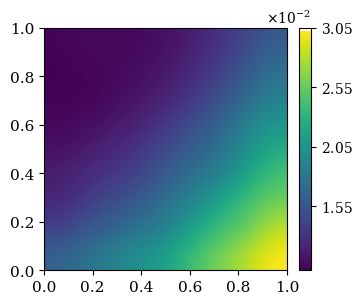

In [ ]:
plt.figure(figsize=(height*1.2, height))

K_diff = torch.mean(torch.abs(K_prediction - K_validation), axis=0).squeeze()
plt.imshow(K_diff, interpolation='bicubic', extent=[0, 1, 0, 1])

cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.formatter = ScalarFormatter(useMathText=True)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()

# Get automatically generated ticks
ticks = cbar.get_ticks()
new_ticks = (ticks + 0.0005)
cbar.set_ticks(new_ticks[1:-1])

plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.tight_layout()

plt.show()

### Flux $q_x(x, y)$

In [118]:
qx_validation = zo.Mx(zo.My(TensOps(torch.Tensor(dataset['qx_val']).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0))).values.detach()
qx_prediction = azo.scalar_product(K_pred, zo.Dx(y_pred, D)).values.detach()

relative_error_stats(qx_validation, qx_prediction)

Mínimo: 3.91e-02
Primer cuartil (Q1): 9.35e-02
Mediana (Q2): 1.32e-01
Tercer cuartil (Q3): 1.82e-01
Máximo: 7.04e+00


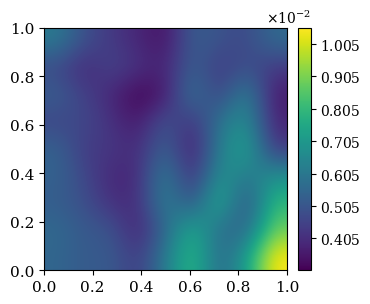

In [ ]:
plt.figure(figsize=(height*1.2, height))

qx_diff = torch.mean(torch.abs(qx_prediction - qx_validation), axis=0).squeeze()
plt.imshow(qx_diff, interpolation='bicubic', extent=[0, 1, 0, 1])

cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.formatter = ScalarFormatter(useMathText=True)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()

# Get automatically generated ticks
ticks = cbar.get_ticks()
new_ticks = (ticks + 0.00005)
cbar.set_ticks(new_ticks[1:-1])

plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.tight_layout()

plt.show()

### Flux $q_y(x, y)$

In [120]:
qy_validation = zo.Mx(zo.My(TensOps(torch.Tensor(dataset['qy_val']).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0))).values.detach()
qy_prediction = azo.scalar_product(K_pred, zo.Dy(y_pred, D)).values.detach()

relative_error_stats(qy_validation, qy_prediction)

Mínimo: 4.52e-02
Primer cuartil (Q1): 9.19e-02
Mediana (Q2): 1.31e-01
Tercer cuartil (Q3): 1.83e-01
Máximo: 3.08e+03


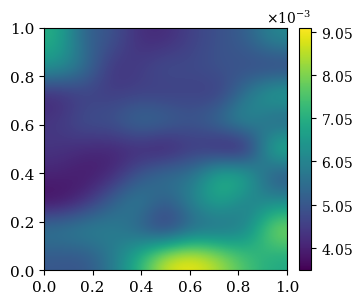

In [ ]:
plt.figure(figsize=(height*1.2, height))

qy_diff = torch.mean(torch.abs(qy_prediction - qy_validation), axis=0).squeeze()
plt.imshow(qy_diff, interpolation='bicubic', extent=[0, 1, 0, 1])

cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.formatter = ScalarFormatter(useMathText=True)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()

# Get automatically generated ticks
ticks = cbar.get_ticks()
new_ticks = (ticks + 0.00005)
cbar.set_ticks(new_ticks[1:-1])

plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.tight_layout()

plt.show()

In [122]:
u_min = um_validation.flatten().min()
u_max = um_validation.flatten().max()
steps = 1000

u_for_validating = torch.linspace(u_min, u_max, steps=steps).view(steps, 1, 1, 1)
K_for_validating = (u_for_validating*(1-u_for_validating)).detach().cpu().numpy()
K_predicted_for_validating = model.explanatory(u_for_validating.to(DEVICE)).detach().cpu().numpy()

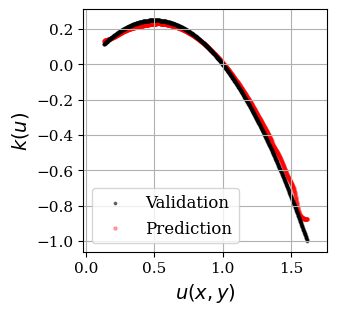

In [ ]:
width = cm_to_in(12)  # image width
height = cm_to_in(8) # image height

plt.figure(figsize=(height, height))
plt.scatter(u_for_validating.flatten(), K_predicted_for_validating.flatten(), label='Prediction', color='red', s=5, alpha=0.3)
plt.scatter(u_for_validating.flatten(), K_for_validating.flatten(), label='Validation', color='black', s=3, alpha=0.5)

plt.xlabel('$u(x, y)$', fontsize=label_fontsize)
plt.ylabel('$k(u)$', fontsize=label_fontsize)

plt.grid(True)
# Get the current legend and change the order
handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 0]  # Change the order of the labels here (Validation first, Prediction second)
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], loc='lower left', fontsize=legend_fontsize)
plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)

min = torch.min(u_for_validating.flatten()) - 0.1*(torch.max(u_for_validating.flatten() - torch.min(u_for_validating.flatten())))
max = torch.max(u_for_validating.flatten()) + 0.1*(torch.max(u_for_validating.flatten() - torch.min(u_for_validating.flatten())))

plt.xlim(min, max)

plt.show()

In [124]:
trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_parameters}")

Trainable parameters: 4501


In [125]:
total_time_seconds = np.cumsum(lists["time_list"])[-1]
total_time_minutes = total_time_seconds / 60

print(f"Total training time: {total_time_seconds:.2f} seconds")
print(f"Total training time: {total_time_minutes:.2f} minutes")

Total training time: 7504.12 seconds
Total training time: 125.07 minutes


In [126]:
diff_squared = (K_predicted_for_validating - K_for_validating) ** 2
true_squared = K_for_validating ** 2

u_vals = u_for_validating.numpy().flatten()

er = (np.sqrt(np.trapz(diff_squared.flatten(), u_vals))) / (np.sqrt(np.trapz(true_squared.flatten(), u_vals)))

print("Explanatory error:")
print(f" er(K): {er:.2e}")

Explanatory error:
 er(K): 8.98e-02
